## Import

In [1]:
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, Trainer, AutoTokenizer
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score,classification_report
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from datasets import Dataset
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer



c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## import der gelablten daten und testsplit

Gelabelte Daten importieren und mergen

In [3]:
DATA_PATH = '../../data/processed/'

In [ ]:
# Neue Testdaten laden
df_posts = pd.read_csv(os.path.join(DATA_PATH, "test_data_posts.csv")).rename(columns={"post_id": "id"})
df_comments = pd.read_csv(os.path.join(DATA_PATH, "test_data_comments.csv")).rename(columns={"comment_id": "id"})

# Vereinheitlichen (id, text, label)
df_posts = df_posts[["id", "text", "label"]]
df_comments = df_comments[["id","text", "label"]]

# Label-Typ absichern und NaNs entfernen
df_posts["label"] = pd.to_numeric(df_posts["label"], errors="coerce")
df_comments["label"] = pd.to_numeric(df_comments["label"], errors="coerce")
df_posts = df_posts.dropna(subset=["label"])
df_comments = df_comments.dropna(subset=["label"])

# Label in int umwandeln
df_posts["label"] = df_posts["label"].astype(int)
df_comments["label"] = df_comments["label"].astype(int)

# Übersicht
print(f"✅ Posts: {len(df_posts)} Beispiele")
print(df_posts["label"].value_counts())

print(f"\n✅ Comments: {len(df_comments)} Beispiele")
print(df_comments["label"].value_counts())

✅ Posts: 400 Beispiele
label
1    263
0    122
2     15
Name: count, dtype: int64

✅ Comments: 999 Beispiele
label
0    333
1    333
2    333
Name: count, dtype: int64


train test split

In [5]:
df_test_posts = df_posts.copy()
df_test_comments = df_comments.copy()


## Modelle

In [6]:
# Modelle definieren
HF_MODELS = {
    "deberta": "microsoft/deberta-v3-base",
    "cryptobert": "ElKulako/cryptobert",
    "finbert": "yiyanghkust/finbert-tone",
    "roberta": "cardiffnlp/twitter-roberta-base-sentiment"
}

CLASSIC_MODELS = {
    "vader": SentimentIntensityAnalyzer(),
    "textblob": "textblob"
}


In [7]:
# Speichern der Ergebnisse separat für Posts und Kommentare.
classification_reports_posts = {}
classification_reports_comments = {}

# Schleife über beide Testdatensätze: Reddit-Posts und Reddit-Kommentare
for dataset_name, current_test_df in [("posts", df_test_posts), ("comments", df_test_comments)]:
    print(f"\nKlassifikationsreport für {dataset_name.upper()}:\n{'='*60}")

    # Temporärer Container für die Reports der aktuellen Runde (Posts oder Kommentare)
    temp_reports = {}

    # Evaluation der transformerbasierten Modelle 
    for name, model_name in HF_MODELS.items():
        print(f"\n{name.upper()} Modell:")

        # Modell und zugehörigen Tokenizer laden
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

        # HuggingFace-kompatibles Dataset erzeugen
        test_dataset = Dataset.from_pandas(current_test_df)

        # Texte tokenisieren (alle auf gleiche Länge kürzen/auffüllen)
        tokenized_test = test_dataset.map(
            lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=256),
            batched=True
        )

        # Spalte "label" in "labels" umbenennen, wie HuggingFace es erwartet
        tokenized_test = tokenized_test.rename_column("label", "labels")

        # Dataset in Torch-Format bringen (für HuggingFace Trainer)
        tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

        # Trainer initialisieren und Vorhersagen berechnen
        trainer = Trainer(model=model, tokenizer=tokenizer)
        predictions = trainer.predict(tokenized_test)

        # Vorhersagen extrahieren
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        # Sonderfall: CryptoBERT hat andere Label-Reihenfolge – nur bei Posts anpassen
        if dataset_name == "posts" and name == "cryptobert":
            label_mapping = {2: 0, 1: 1, 0: 2}
            y_pred = [label_mapping[p] for p in y_pred]

        # Klassifikationsreport erzeugen (enthält z. B. F1-Score pro Klasse)
        report = classification_report(
            y_true, y_pred,
            target_names=['bullish', 'neutral', 'bearish'],
            output_dict=True
        )

        # Report im temporären Container speichern
        temp_reports[name] = report

    # Evaluation der lexikonbasierten Modelle (VADER und TextBlob)
    for name, model_obj in CLASSIC_MODELS.items():
        print(f"\n{name.upper()} Modell:")
        preds = []

        # Alle Texte im Datensatz klassifizieren
        for text in current_test_df["text"]:
            if name == "vader":
                # VADER gibt einen compound-Score zurück
                score = model_obj.polarity_scores(text)["compound"]
                # Schwellenwerte für bullish/neutral/bearish
                preds.append(0 if score >= 0.05 else 2 if score <= -0.05 else 1)

            elif name == "textblob":
                # TextBlob verwendet Polarity von -1 bis 1
                polarity = TextBlob(text).sentiment.polarity
                preds.append(0 if polarity >= 0.05 else 2 if polarity <= -0.05 else 1)

        # Klassifikationsreport erzeugen
        report = classification_report(
            current_test_df["label"], preds,
            target_names=['bullish', 'neutral', 'bearish'],
            output_dict=True
        )

        # Report speichern
        temp_reports[name] = report

    # Die Ergebnisse dieser Runde (Posts oder Kommentare) in den Hauptcontainer schreiben
    if dataset_name == "posts":
        classification_reports_posts = temp_reports
    else:
        classification_reports_comments = temp_reports



Klassifikationsreport für POSTS:

DEBERTA Modell:


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 400/400 [00:00<00:00, 3234.26 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureW

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CRYPTOBERT Modell:


Map: 100%|██████████| 400/400 [00:00<00:00, 3172.58 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



FINBERT Modell:


Map: 100%|██████████| 400/400 [00:00<00:00, 5448.23 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



ROBERTA Modell:


Map: 100%|██████████| 400/400 [00:00<00:00, 6304.64 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



VADER Modell:

TEXTBLOB Modell:

Klassifikationsreport für COMMENTS:

DEBERTA Modell:


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 999/999 [00:00<00:00, 9296.73 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureW

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CRYPTOBERT Modell:


Map: 100%|██████████| 999/999 [00:00<00:00, 13721.69 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



FINBERT Modell:


Map: 100%|██████████| 999/999 [00:00<00:00, 9997.78 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



ROBERTA Modell:


Map: 100%|██████████| 999/999 [00:00<00:00, 11943.28 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_19352\2092533091.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)



VADER Modell:

TEXTBLOB Modell:


## Plot

In [8]:
# Hilfsfunktion zur Extraktion der F1-Scores
def extract_f1_scores(classification_reports):
    f1_data = {}
    for model, report in classification_reports.items():
        f1_data[model] = {
            "bullish": report["bullish"]["f1-score"],
            "neutral": report["neutral"]["f1-score"],
            "bearish": report["bearish"]["f1-score"]
        }
    return f1_data

# F1-Scores extrahieren
f1_posts = extract_f1_scores(classification_reports_posts)
f1_comments = extract_f1_scores(classification_reports_comments)

# Ausgabe
print("📊 F1-Scores pro Klasse – POSTS")
for model, scores in f1_posts.items():
    print(f"\n{model.upper()}:")
    for cls, score in scores.items():
        print(f"  {cls}: {score:.4f}")

print("\n" + "="*60)
print("📊 F1-Scores pro Klasse – COMMENTS")
for model, scores in f1_comments.items():
    print(f"\n{model.upper()}:")
    for cls, score in scores.items():
        print(f"  {cls}: {score:.4f}")


📊 F1-Scores pro Klasse – POSTS

DEBERTA:
  bullish: 0.0000
  neutral: 0.1315
  bearish: 0.0720

CRYPTOBERT:
  bullish: 0.4313
  neutral: 0.5714
  bearish: 0.1250

FINBERT:
  bullish: 0.4550
  neutral: 0.2334
  bearish: 0.0000

ROBERTA:
  bullish: 0.1800
  neutral: 0.6460
  bearish: 0.0171

VADER:
  bullish: 0.4862
  neutral: 0.1538
  bearish: 0.0769

TEXTBLOB:
  bullish: 0.4750
  neutral: 0.3743
  bearish: 0.0000

📊 F1-Scores pro Klasse – COMMENTS

DEBERTA:
  bullish: 0.5004
  neutral: 0.0000
  bearish: 0.0000

CRYPTOBERT:
  bullish: 0.9162
  neutral: 0.6289
  bearish: 0.7514

FINBERT:
  bullish: 0.4866
  neutral: 0.1561
  bearish: 0.0886

ROBERTA:
  bullish: 0.4458
  neutral: 0.3904
  bearish: 0.3327

VADER:
  bullish: 0.2534
  neutral: 0.3244
  bearish: 0.2144

TEXTBLOB:
  bullish: 0.2909
  neutral: 0.3702
  bearish: 0.2364


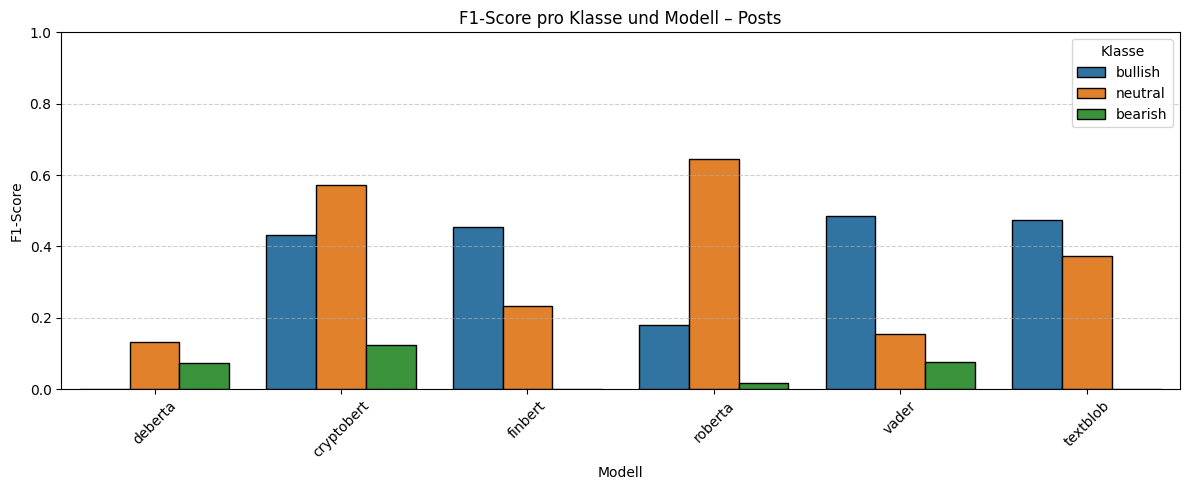

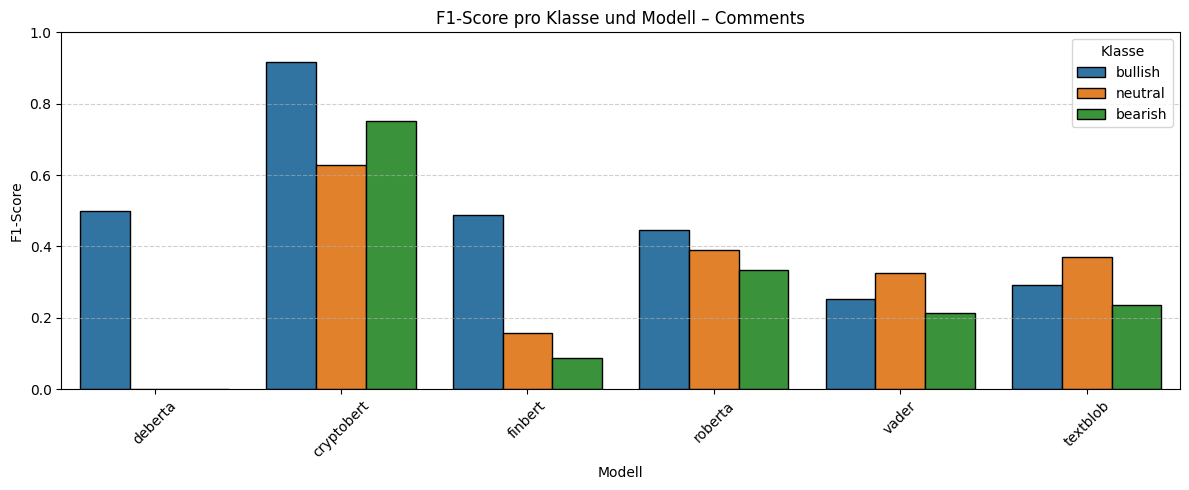

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# In DataFrames umwandeln
df_posts = pd.DataFrame(f1_posts).T.reset_index().rename(columns={"index": "model"})
df_comments = pd.DataFrame(f1_comments).T.reset_index().rename(columns={"index": "model"})

# Melt für Plots – nur über die Klassen (nicht über "type" oder sonstiges)
df_posts_melted = df_posts.melt(id_vars=["model"], 
                                value_vars=["bullish", "neutral", "bearish"],
                                var_name="class", value_name="f1_score")

df_comments_melted = df_comments.melt(id_vars=["model"], 
                                      value_vars=["bullish", "neutral", "bearish"],
                                      var_name="class", value_name="f1_score")

# Plot: POSTS
plt.figure(figsize=(12, 5))
sns.barplot(data=df_posts_melted, x="model", y="f1_score", hue="class", edgecolor="black")
plt.title("F1-Score pro Klasse und Modell – Posts")
plt.ylabel("F1-Score")
plt.xlabel("Modell")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Klasse")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: COMMENTS
plt.figure(figsize=(12, 5))
sns.barplot(data=df_comments_melted, x="model", y="f1_score", hue="class", edgecolor="black")
plt.title("F1-Score pro Klasse und Modell – Comments")
plt.ylabel("F1-Score")
plt.xlabel("Modell")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="Klasse")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
